In [ ]:
!pip install -r requirements.txt

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import kaleido

import os.path
from os import path

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2023-08-07 13:12:36.180063: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 13:12:36.220927: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-07 13:12:36.221450: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 13:12:36.981811: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
def fetch_data():
    yf.pdr_override()
    tech_list = ['BABA','AAPL','GOOG','AMZN','TSLA','MSFT']

    end = datetime(datetime.now().year, datetime.now().month - 1, datetime.now().day)
    start = datetime(end.year - 10, end.month, end.day)
    for stock in tech_list:
        globals()[stock] = yf.download(stock, start, end)
    
    company_list = [BABA,AAPL,GOOG,AMZN,TSLA,MSFT]
    
    for company, com_name in zip(company_list, tech_list):
        company.to_csv(f'src/{com_name}_STOCK.csv', mode='w')

In [3]:
fetch_data()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
def monthly_fetch_data(stock_code):
    yf.pdr_override()

    end = datetime.now()
    start = datetime(end.year, end.month - 1, end.day)
    
    return yf.download(stock_code, start, end)

In [5]:
def plot_closing_price(stock_code):
    st = pd.read_csv(f'src/{stock_code}_STOCK.csv')
    st['Date'] = pd.to_datetime(st['Date'])
    fig = go.Figure([go.Scatter(x=st['Date'],y=st['Adj Close'])])
    fig.update_layout(
        title=f'Closing Price of {stock_code}',
        yaxis_title='Adj Close'
    )
    fig.write_image(f'/home/thien/stock-prediction/img/close/{stock_code}_CLOSING_PRICE.png', engine='kaleido')
    
def plot_sales_volume(stock_code):
    st = pd.read_csv(f'src/{stock_code}_STOCK.csv')
    st['Date'] = pd.to_datetime(st['Date'])
    fig = go.Figure([go.Scatter(x=st['Date'],y=st['Volume'])])
    fig.update_layout(
        title=f'Sales Volume of {stock_code}',
        yaxis_title='Volume'
    )
    fig.write_image(f'/home/thien/stock-prediction/img/volume/{stock_code}_SALES_VOLUME.png', engine='kaleido')

def moving_average(stock_code):
    st = pd.read_csv(f'src/{stock_code}_STOCK.csv')
    st['Date'] = pd.to_datetime(st['Date'])
    ma_day = [10,20,50]

    for ma in ma_day:
        col_name = f'MA for {ma} days'
        st[col_name] = st['Adj Close'].rolling(ma).mean()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=st['Date'],y=st['Adj Close'],name='Adj Close'))
    fig.add_trace(go.Scatter(x=st['Date'],y=st['MA for 10 days'],name='MA for 10 days'))
    fig.add_trace(go.Scatter(x=st['Date'],y=st['MA for 20 days'],name='MA for 20 days'))
    fig.add_trace(go.Scatter(x=st['Date'],y=st['MA for 50 days'],name='MA for 50 days'))
    fig.update_layout(
        title = f'Moving Average (MA) of {stock_code}'
    )
    fig.write_image(f'/home/thien/stock-prediction/img/ma/{stock_code}_MA.png', engine='kaleido')

def daily_return(stock_code):
    st = pd.read_csv(f'src/{stock_code}_STOCK.csv')
    st['Date'] = pd.to_datetime(st['Date'])
    st['Daily Return'] = st['Adj Close'].pct_change()
    
    fig = go.Figure([go.Scatter(x=st['Date'],y=st['Daily Return'])])
    fig.update_layout(
        title=f'Daily Return of {stock_code}',
        yaxis_title='Percentage (%)'
    )
    fig.write_image(f'/home/thien/stock-prediction/img/daily_return/{stock_code}_DAILY_RETURN.png', engine='kaleido')

In [ ]:
plot_closing_price('AAPL')
plot_sales_volume('AAPL')
moving_average('AAPL')
daily_return('AAPL')

In [13]:
def stockpredict(stock_code):
    data_train = pd.read_csv(f'/home/thien/stock-prediction/src/{stock_code}_STOCK.csv')
    training_set = data_train.iloc[:, 3:4].values

    # Scaling using MinMaxScaler
    sc = MinMaxScaler(feature_range = (0, 1))
    training_set_scaled = sc.fit_transform(training_set)

    # Create train data
    X_train = []
    y_train = []
    no_of_sample = len(training_set)

    for i in range(60, no_of_sample):
        X_train.append(training_set_scaled[i-60:i, 0])
        y_train.append(training_set_scaled[i, 0])

    X_train, y_train = np.array(X_train), np.array(y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    
    # building the RNN LSTM model
    regressor = Sequential()
    regressor.add(LSTM(32,input_shape=(X_train.shape[1],1)))
    regressor.add(Dropout(0.2))
    regressor.add(Dense(1))
    regressor.compile(optimizer='adam',loss='mse')
    
    if path.exists(f"/home/thien/stock-prediction/models/{stock_code}-stockmodel.keras"):
        regressor.load_weights(f"/home/thien/stock-prediction/models/{stock_code}-stockmodel.keras")
    else:
        regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)
        regressor.save(f"/home/thien/stock-prediction/models/{stock_code}-stockmodel.keras")
        
    # Predict
    data_test = monthly_fetch_data(stock_code)
    data_test.to_csv(f'src/{stock_code}_STOCK.csv', mode='a',header=None)
    real_stock_price = data_test.iloc[:, 3:4].values

    data_total = pd.concat((data_train['Close'], data_test['Close']), axis = 0)
    inputs = data_total[len(data_total) - len(data_test) - 60:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    X_test = []
    no_of_sample = len(inputs)
    
    for i in range(60, no_of_sample):
        X_test.append(inputs[i-60:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    predicted_stock_price = regressor.predict(X_test)
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)

    predict_loss=0
    for i in range(len(real_stock_price)):
        predict_loss += abs((real_stock_price[i] - predicted_stock_price[i])/real_stock_price[i])*100
    predict_loss = round(float(predict_loss / len(real_stock_price)), 2)
    acr = 100-predict_loss
    print(f'Accuracy: {acr}')

    # Plot
    plt.plot(real_stock_price, color = 'red', label = f'Real {stock_code} Stock Price')
    plt.plot(predicted_stock_price, color = 'blue', label = f'Predicted {stock_code} Stock Price')
    plt.title(f'{stock_code} Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel(f'{stock_code} Stock Price')
    plt.legend()
    plt.savefig(f'/home/thien/stock-prediction/img/predict/{stock_code}-prediction.png')
    

Epoch 1/100
79/79 [==============================] - 6s 38ms/step - loss: 0.0350
Epoch 2/100
79/79 [==============================] - 3s 36ms/step - loss: 0.0036
Epoch 3/100
79/79 [==============================] - 4s 48ms/step - loss: 0.0033
Epoch 4/100
79/79 [==============================] - 4s 47ms/step - loss: 0.0027
Epoch 5/100
79/79 [==============================] - 4s 50ms/step - loss: 0.0024
Epoch 6/100
79/79 [==============================] - 4s 48ms/step - loss: 0.0024
Epoch 7/100
79/79 [==============================] - 4s 51ms/step - loss: 0.0023
Epoch 8/100
79/79 [==============================] - 4s 50ms/step - loss: 0.0021
Epoch 9/100
79/79 [==============================] - 4s 46ms/step - loss: 0.0020
Epoch 10/100
79/79 [==============================] - 4s 47ms/step - loss: 0.0019
Epoch 11/100
79/79 [==============================] - 3s 44ms/step - loss: 0.0018
Epoch 12/100
79/79 [==============================] - 3s 37ms/step - loss: 0.0019
Epoch 13/100
79/79 [=====

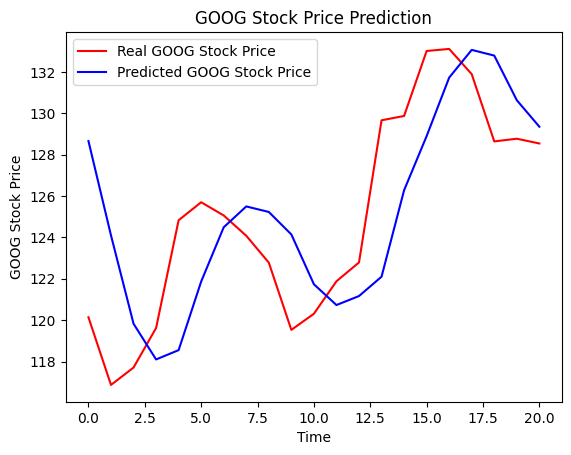

In [14]:
stockpredict('GOOG')